In [1]:


import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch.nn import functional as F
from torchvision import  transforms
import scipy.stats as stats
from sklearn.decomposition import PCA
import torch.optim as optim
import tqdm
import os
from torch.utils.data import DataLoader
%matplotlib inline
from torchsummary import summary
import seaborn as sns
sns.set()




In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs=30
BATCH_SIZE=256
SHUFFLE_DATASET =True
NUM_DATALOADER_WORKERS = 1


data_root='.'

class Rescale(object):
    def __call__(self,image):
        image = image-image.min()
        image = image/image.max()
        return image


In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
 Rescale() ])
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
])

train_loader = torch.utils.data.DataLoader(
            dataset= torchvision.datasets.MNIST(
                root = data_root,
                train=True,
                transform=transform,
                download = True
                ),
            batch_size=BATCH_SIZE,
            shuffle = SHUFFLE_DATASET,
            num_workers =NUM_DATALOADER_WORKERS
)

test_loader = torch.utils.data.DataLoader(
            dataset= torchvision.datasets.MNIST(
                root = data_root,
                train=False,
                transform=mnist_transformations,
                ),
            batch_size=BATCH_SIZE,
            shuffle = False,
            num_workers =NUM_DATALOADER_WORKERS)

In [4]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=64),
            nn.Dropout(0.3),
        )
        self.mu = nn.Linear(64, 2)
        self.sigma = nn.Linear(64, 2)

    def forward(self, x):
        x = x.view(-1, 784)
        hidden_layers = self.encoder(x)
        mu = self.mu(hidden_layers)
        sigma = self.sigma(hidden_layers)
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=256, out_features=784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, log_var = self.encoder(x)
        h = self.reparameterize(mu, log_var)
        return self.decoder(h), mu, log_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        h = mu + eps * std
        return h

In [5]:
def vae_loss(x, x_hat, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = (recon_loss + kl_loss) / x.size(0)
    return total_loss
    


In [6]:
autoencoder = Autoencoder()

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [7]:
train_loss=[]
for epoch in range(50):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data  
        inputs = inputs.to(device)  
        optimizer.zero_grad()
        outputs, mu, log_var = autoencoder(inputs)
        loss= vae_loss(inputs,outputs,mu,log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
  
    train_loss.append(round(running_loss/len(train_loader),3))
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_loader)}")

Epoch 1 loss: 56.98720865452543
Epoch 2 loss: 45.17820467035821
Epoch 3 loss: 42.460665861089176
Epoch 4 loss: 41.25066677661652
Epoch 5 loss: 40.39918453135389
Epoch 6 loss: 39.89610141186004
Epoch 7 loss: 39.445946729944104
Epoch 8 loss: 39.08304386544735
Epoch 9 loss: 38.703989718822726
Epoch 10 loss: 38.42992071598134
Epoch 11 loss: 38.164536707452
Epoch 12 loss: 37.91055473165309
Epoch 13 loss: 37.71522659951068
Epoch 14 loss: 37.529315218012385
Epoch 15 loss: 37.33769164389752
Epoch 16 loss: 37.15145213350337
Epoch 17 loss: 37.068208816203665
Epoch 18 loss: 36.92558410319876
Epoch 19 loss: 36.79867448198034
Epoch 20 loss: 36.682038343713636
Epoch 21 loss: 36.57713973674368
Epoch 22 loss: 36.45313868421189
Epoch 23 loss: 36.38197070182638
Epoch 24 loss: 36.31649290044257
Epoch 25 loss: 36.24547893443006
Epoch 26 loss: 36.18549496265168
Epoch 27 loss: 36.12570297565866
Epoch 28 loss: 36.11667365216194
Epoch 29 loss: 36.02071226404068
Epoch 30 loss: 35.98868263731612
Epoch 31 loss: 

<Axes: >

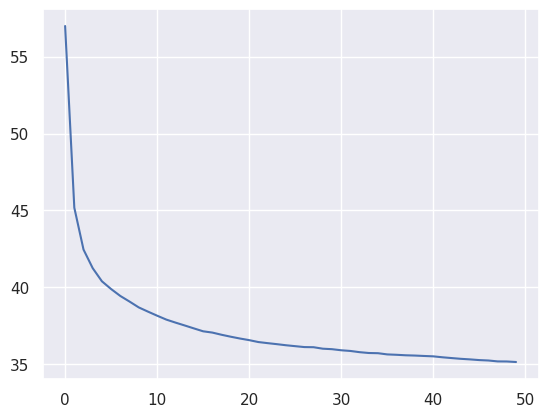

In [8]:

sns.lineplot(train_loss)

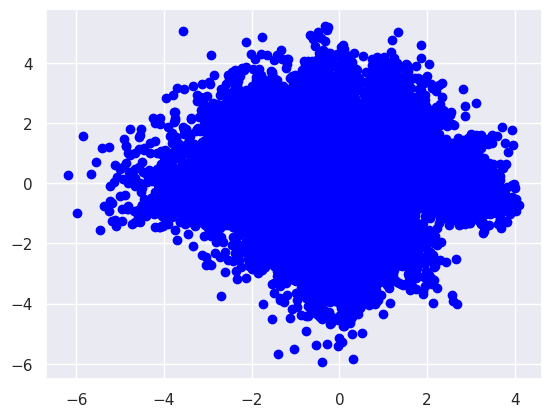

In [9]:
for dataiter in train_loader:
    images, labels = dataiter
    hidden_l = autoencoder.encoder(images)
    plt.scatter(hidden_l[0].detach().numpy()[:,0], hidden_l[0].detach().numpy()[:,1],color='blue')

<ipython-input-10-be6ae9959760>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


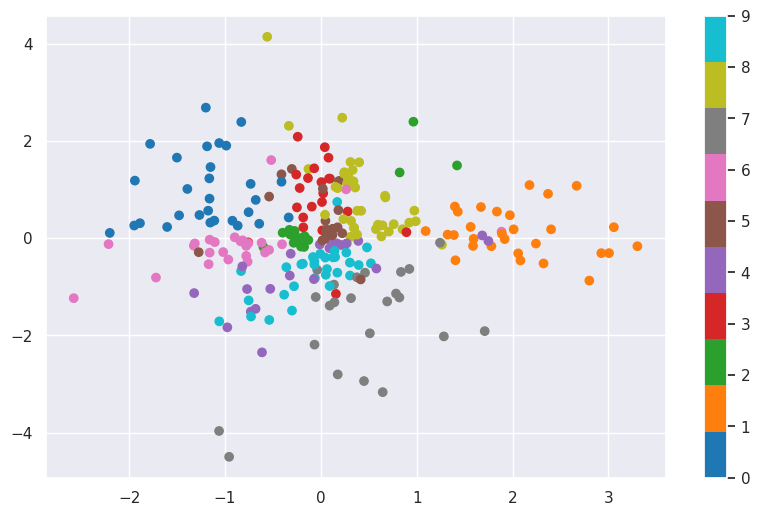

In [10]:
import matplotlib.cm as cm
# Take 1 batch and plot hidden space
dataiter = iter(train_loader)
images, labels = next(dataiter)
hidden_l = autoencoder.encoder(images)

# Define a colormap with a larger number of colors
cmap = cm.get_cmap('tab10')

plt.figure(figsize=(10, 6))
scatter = plt.scatter(hidden_l[0].detach().numpy()[:, 0], hidden_l[0].detach().numpy()[:, 1], c=labels.numpy(), cmap=cmap)
plt.colorbar(scatter)
plt.show()

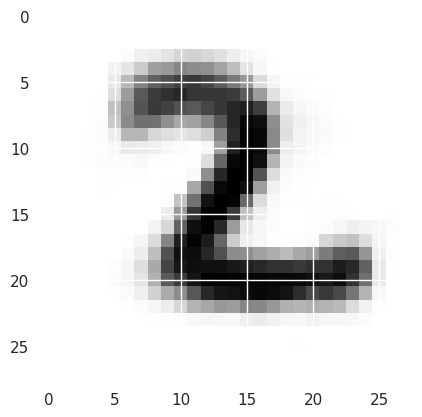

In [15]:
# Take vector for decoder from space
new_images = autoencoder.decoder(torch.tensor([[1.1,5.]]))  
for image in new_images:
    image = image.squeeze(0)
    plt.imshow(image.detach().numpy(), cmap='binary')
    plt.show()

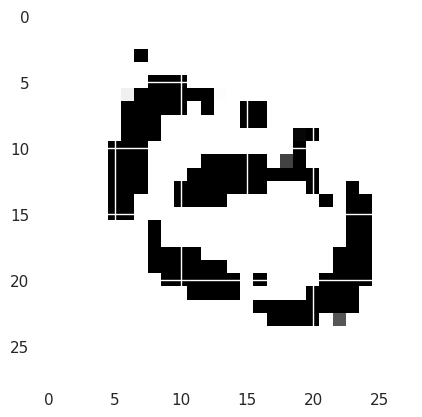

In [16]:
# Take vector for decoder not from space
new_images = autoencoder.decoder(torch.tensor([[-150.1,1034.]]))  
for image in new_images:
    image = image.squeeze(0)
    plt.imshow(image.detach().numpy(), cmap='binary')
    plt.show()

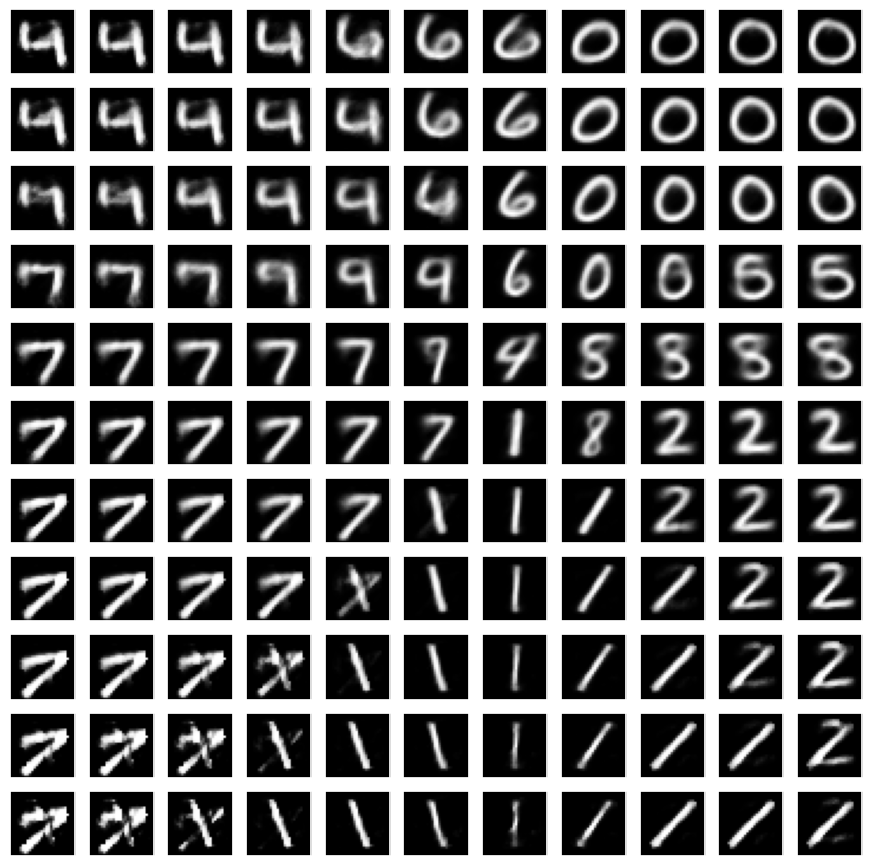

In [13]:
n = 5
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = autoencoder.decoder(torch.tensor([[float(4*i/n+1), float(4*j/n-1)]]))
    plt.imshow(img.squeeze().detach().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

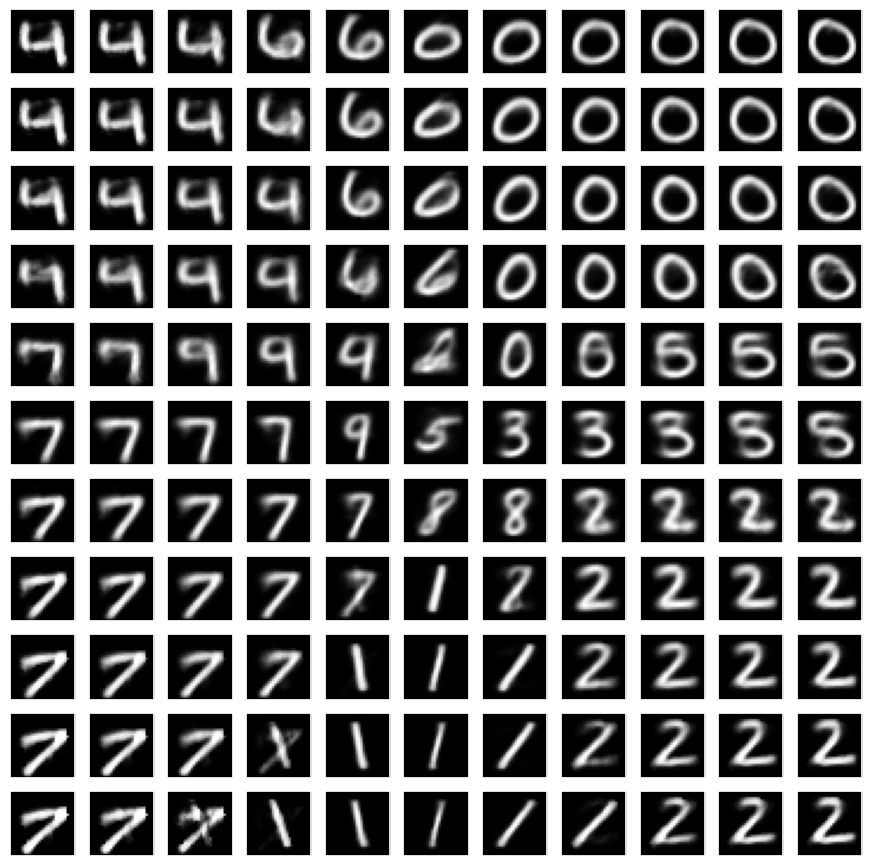

In [14]:
n = 5
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = autoencoder.decoder(torch.tensor([[float(3*i/n), float(4*j/n)]]))
    plt.imshow(img.squeeze().detach().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)